In [ ]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 71689, done.
remote: Total 71689 (delta 0), reused 0 (delta 0), pack-reused 71689
Receiving objects: 100% (71689/71689), 578.86 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (50711/50711), done.


In [ ]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!cd models/research && \
    cp object_detection/packages/tf2/setup.py . && \
    python -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.1 MB 5.2 MB/s 
     |████████████████████████████████| 352 kB 47.7 MB/s 
     |████████████████████████████████| 2.2 MB 40.4 MB/s 
     |████████████████████████████████| 23.4 MB 64.3 MB/s 
     |████████████████████████████████| 4.9 MB 11.3 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 99 kB 3.0 MB/s 
     |████████████████████████████████| 636 kB 36.9 MB/s 
     |████████████████████████████████| 47.8 MB 65 kB/s 
     |████████████████████████████████| 90 kB 10.1

In [ ]:
!cd models/research && python object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-04-06 12:08:26.676466: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0406 12:08:27.471247 139787636533120 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 4.28s
I0406 12:08:28.179728 139787636533120 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 4.28s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 1.71s
I0406 12:08:29.894002 139787636533120 test

In [ ]:
import os
import pathlib
import tensorflow as tf

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/jungle.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/intersection.jpeg

--2022-04-06 12:09:06--  https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195368 (191K) [image/jpeg]
Saving to: ‘walkingdog.jpeg’

walkingdog.jpeg     100%[===================>] 190.79K   547KB/s    in 0.3s    

2022-04-06 12:09:07 (547 KB/s) - ‘walkingdog.jpeg’ saved [195368/195368]

--2022-04-06 12:09:07--  https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160514 (157K) [image/jpeg]
Saving to: ‘traffic.jpeg’

traffic.jpeg        100

In [ ]:
IMAGE_PATHS = [
  'intersection.jpeg', 'traffic.jpeg', 'jungle.jpeg', 'walkingdog.jpeg']

In [ ]:
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz'

PATH_TO_MODEL_DIR = tf.keras.utils.get_file(
    fname='ssd_resnet101_v1_fpn_640x640_coco17_tpu-8',
    origin=url,
    untar=True)

386539520/386527459 [==============================] - 5s 0us/step


In [ ]:
PATH_TO_MODEL_DIR

'/root/.keras/datasets/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8'

In [ ]:
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

PATH_TO_LABELS = tf.keras.utils.get_file(
    fname='mscoco_label_map.pbtxt',
    origin=url,
    untar=False)

16384/5056 [=================================================================================================] - 0s 0us/step


In [ ]:
PATH_TO_LABELS

'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [ ]:
!head {PATH_TO_LABELS}

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


In [ ]:
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 36.989256620407104 seconds


In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_TO_LABELS,
    use_display_name=True)

In [ ]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [ ]:
def load_image_into_numpy_array(path):
    
    return np.array(Image.open(path))

In [ ]:
def detect_objects(image_path):
  print('Running inference for {}... '.format(image_path), end='')

  image_np = load_image_into_numpy_array(image_path)

  input_tensor = tf.convert_to_tensor(image_np)

  input_tensor = input_tensor[tf.newaxis, ...]

  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
  detections['num_detections'] = num_detections

  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False
  )

  plt.figure(figsize=(15, 10))
  plt.imshow(image_np_with_detections)
  plt.show();


Running inference for intersection.jpeg... 

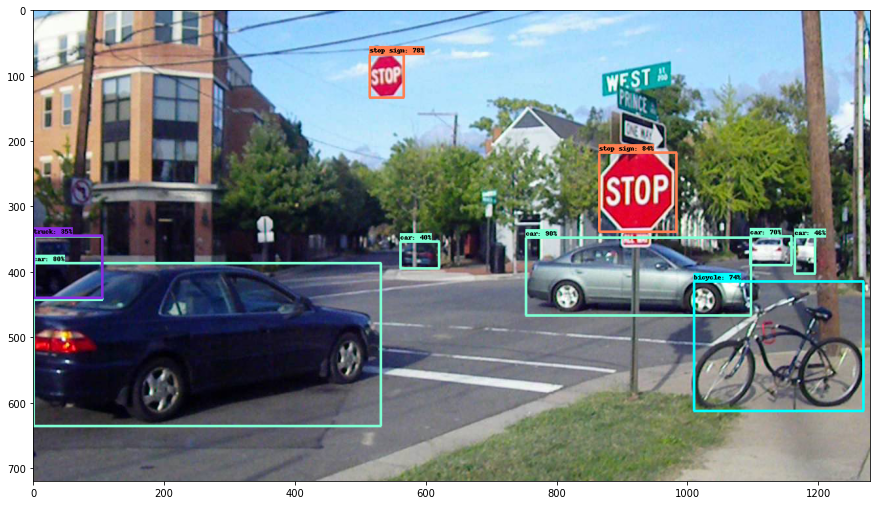

In [ ]:
detect_objects(IMAGE_PATHS[0])

## Videos

In [ ]:
!wget -nc https://lazyprogrammer.me/cnn_class2_videos.zip

--2022-04-06 12:34:38--  https://lazyprogrammer.me/cnn_class2_videos.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2073140 (2.0M) [application/zip]
Saving to: ‘cnn_class2_videos.zip’

cnn_class2_videos.z 100%[===================>]   1.98M  1.30MB/s    in 1.5s    

2022-04-06 12:34:41 (1.30 MB/s) - ‘cnn_class2_videos.zip’ saved [2073140/2073140]



In [ ]:
!unzip cnn_class2_videos.zip

Archive:  cnn_class2_videos.zip
  inflating: catdog.mp4              
  inflating: safari.mp4              
  inflating: traffic.mp4             


In [ ]:
INPUT_VIDEOS = ['catdog', 'safari', 'traffic']

In [ ]:
def detect_objects_in_image(image_np):
  #print('Running inference for {}... '.format(image_path), end='')

  #image_np = load_image_into_numpy_array(image_path)

  input_tensor = tf.convert_to_tensor(image_np)

  input_tensor = input_tensor[tf.newaxis, ...]

  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
  detections['num_detections'] = num_detections

  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False
  )

  return image_np_with_detections


In [ ]:
import imageio

def detect_objects_in_video(input_video):
  print(f'Running inference for {input_video}.mp4... ', end='')

  video_reader = imageio.get_reader(f'{input_video}.mp4')
  video_writer = imageio.get_writer(f'{input_video}_annotated.mp4', fps=10)

  t0 = time.time()
  n_frames = 0
  for frame in video_reader:
    n_frames += 1
    new_frame = detect_objects_in_image(frame)

    video_writer.append_data(new_frame)

  fps = n_frames / (time.time() - t0)
  print("Frames processed: %s, Speed: %s fps" % (n_frames, fps))

    # clean up
  video_writer.close()

In [ ]:
detect_objects_in_video(INPUT_VIDEOS[0])

Running inference for catdog.mp4... Frames processed: 50, Speed: 2.1208315294003763 fps


## Trying object detection with webcam


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  
  with open(filename, 'wb') as f:
    f.write(binary)
  filename = detect_objects_webcam(filename)
  return filename

In [ ]:
def detect_objects_webcam(image_path):
  print('Running inference for {}... '.format(image_path), end='')

  image_np = load_image_into_numpy_array(image_path)

  input_tensor = tf.convert_to_tensor(image_np)

  input_tensor = input_tensor[tf.newaxis, ...]

  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
  detections['num_detections'] = num_detections

  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False
  )

  return image_np_with_detections

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  #print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(detect_objects_webcam(filename)))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

ReferenceError: takePhoto is not defined
